In this post, we will revisit the topic of recurrent neural networks, or RNNs. Although we have used RNNs before in a previous post on character-based text prediction, we glossed over LSTM and assumed it as a black box that just worked. Today, we will take a detailed look at how LSTMs work by dissecting its components. 

Note that this post was inspired by [this article](https://wiseodd.github.io/techblog/2016/08/12/lstm-backprop/) by Kristiadi. I also heavily referenced [this post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah. If you find any part of this article intriguing and intellectually captivating, you will surely enjoy reading their blogs as well. With this in mind, let's jump right into it.

## Disecting LSTMs

Long Short-Term Memory networks, or LSTMs for short, are one of the most widely used building blocks of Recurrent Neural Networks, or RNNs. This is because LSTMs overcame many of the limitations of basic vanilla RNNs: while simple RNN gates are bad at retaining long-term information and only remember input information that were fed into it relatively recenty, LSTMs do a great job of retaining important information, even if they were fed into the cell long time ago. In other words, they are able to somewhat mimic the function of the brain, which involves both long and short-term memory. 

The structure of an LSTM cell might be summarized as follows:

$$
\begin{align}
f_t = \sigma(W_f [h_{t - 1}, x_t] + b_f) \tag{1} \\ 
i_t = \sigma(W_i [h_{t - 1}, x_t] + b_i) \tag{2} \\
\tilde{C}_t = \text{tanh}(W_C [h_{t - 1}, x_t] + b_C) \tag{3} \\
C_t = f_t \odot C_{t - 1} + i_t \odot \tilde{C}_t \tag{4} \\
o_t = \sigma(W_o [h_{t - 1}, x_t] + b_o) \tag{5}\\
h_t = o_t \odot \text{tanh}(C_t) \tag{6} \\
\hat{y} = \text{softmax}(W_y h_t + b_y) \tag{7}
\end{align}
$$

Note that $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)), which is nothing more than just the element-wise multiplication of matrices. 

This long list of equations surely looks like a lot, but each of them has a specific purpose. Let's take a look.

## Forget Gate

The first component of LSTM is the forget gate. This corresponds to these two set of equations:

$$
\begin{align}
f_t = \sigma(W_f [h_{t - 1}, x_t] + b_f) \tag{1} \\ 
C_t = f_t \odot C_{t - 1} + i_t \odot \tilde{C}_t \tag{4} \\
\end{align}
$$

(1) is nothing more than just the good old forward pass. We concatenate $h_{t - 1}$ and $x_t$, then multiply it with some weights, add a bias, and apply a sigmoid activation. At this point, you might be wondering why we use a sigmoid activation instead of something like ReLU. The reason behind this choice of activation function becomes apparent once we look at (4), which is how LSTM imitates forgetting. For now, we will only focus on the first term in (4).

Recall that the output of a sigmoid activatiion is between 0 and 1. Say the output of applying a sigmoid activation results in some value that is very close to 0. In that case, calculating the Hadamard product will also result in a value of an entry very close to 0. Given the interpretation that $C_t$, also known as the cell state, is an artifical way of simulating long-term memory, we can see how having zeros is similar to forgetfulness: a zero entry effectively means that the network deemed a particular piece of information as obsolete and decided to forget it in favor of accepting new information. In short, the sigmoid activation and the Hadamard product form the basis of LSTM's forget gate. By now, it should be apparent why we use sigmoid activations: instead of causing divergence with something like ReLU, we want to deliberately saturate and cause the network to produce some "vanishing" values.

## Updating Cell State

But if our LSTM network only keeps forgetting, obviously this is going to be problematic. Instead, we also want to update the cell state using the new input values.

Let's take a look at the cell state equation again:

$$
C_t = f_t \odot C_{t - 1} + i_t \odot \tilde{C}_t \tag{4}
$$

Previously when discussing the forget gate, we focused only on the first term. Taking a look at the second term, we note that the term is adding some value to the cell state that has been updated to forget information. It only makes sense, then, for the second term to perform the information update sequence. But to understand the second term, we need to take a look at two other equations:

$$
\begin{align}
i_t = \sigma(W_i [h_{t - 1}, x_t] + b_i) \tag{2} \\
\tilde{C}_t = \text{tanh}(W_C [h_{t - 1}, x_t] + b_C) \tag{3} \\
\end{align}
$$

(2) is another forward pass involving concatenation, much like we saw in (1) with $f_t$. The only difference is that, instead of forgetting, $i_t$ is meant to simulate an update of the cell state. In some LSTM variants, $i_t$ is simply replaced with $1 - f_t$, in which cas the cell state update would be rewritten as

$$
C_t = f_t \odot C_{t - 1} + (1 - f_t) \odot \tilde{C}_t \tag{4-2}
$$

However, we will stick to the convention that uses $i_t$ instead of the simpler variant as shown in (4-2). 

The best way to think of $i_t$ or $f_t$ is a filter: $i_t$ is a filter that determines which information to be updated and passed onto the cell state. Now all we need are the raw materials to pass into that filter. The raw material is $\tilde{C}_t$, defined in (3). Notice that we use a $\text{tanh}$ activation instead of a sigmoid, since the aim of (3) is not to produce a filter with sparse entries, but rather to generate substance, or potential information to be stored in memory. This is more in line with the classic vanilla neural network architecture we are familiar with. 

Now, we can finally glue the pieces together to understand (4): we enforce forgetfulness, then supply the cell state with new information. This is now the updated cell state, which gets passed onto the next sequence as new inputs are fed into the LSTM.

## Generating Output

So far, we have only looked at the recurrent features of LSTM; in other words, how it uses information from the past to update its knowledge in the present at time $t$. However, we haven't yet discussed the most important part of any neural network: generating output. 

Obviously, all that hassle of forgetting and updating the cell state would be utterly meaningless if the cell state is not used to generate output. The whole purpose of maintaining a cell state, therefore, is to imitate long and short-term memory of the brain to generate some output. Thus, it is no surprise that the following two equations are structured the way they are:

$$
\begin{align}
o_t = \sigma(W_o [h_{t - 1}, x_t] + b_o) \tag{5}\\
h_t = o_t \odot \text{tanh}(C_t) \tag{6} 
\end{align}
$$

First, we see the familiar forward pass, a familiar structure we have seen earlier. Borrowing the analogy we established in the previous post, $o_t$ is a filter that decides which information to use and drop. The raw material that we pass into this filter is in fact the cell state, processed by a $\text{tanh}$ activation function. This is also a familiar structure we saw earlier in the information update sequence of the network. Only this time, we use the cell state to generate output. This makes sense somewhat intuitively, since the cell state is essentially the memory of the network, and hence to generate output would require the use of this memory. Of course, this should not be construed so literally since what ultimately happens during backpropagation is entirely up to the network, and at that point we simply lay back and hope for the network to learn the best. This point notwithstanding, I find this admittedly coarse heuristic to be nonetheless useful in intuiting the clockwork behind LSTMs. 

At this point, we're not quite done yet; $h$ is not a vector of probabilities indicating which letter is the most likely in a one-hot encoded representation. Therefore, we will need to pass it through another affine layer, than apply a softmax activation. Hence, 

$$
\hat{y} = \text{softmax}(W_y h_t + b_y) \tag{7}
$$

$\hat{y}$ is the final output of an LSTM layer.

# Backward Propagation

Here comes the tricky part: backprop. Thankfully, backprop is somewhat simple in the case of LSTMs due to the use of Hadamard products. The routine is not so much different from a vanilla neural network, so let's try to hash out the equations. 


As we already know, backpropagation in neural networks is merely an extended application of the chain rule, with some minor caveats that matrix calculus entails. 

First, let's begin slow and easy by deriving the expressions for the derivative of the sigmoid and the $\text{tanh}$ functions. First, below is the derivative of the sigmoid with respect to $x$, the input. Recall that the sigmoid function is defined as `1 / (1 + np.exp(-x))`.

$$
\begin{align}
\frac{d \sigma}{dx} 
&= \frac{d}{dx} \left[ \frac{1}{1 + e^{-x}} \right] \\
&= - (1 + e^{-x})^{-2} \cdot (- e^{-x}) \\ 
&= \sigma(x) \cdot \frac{e^{-x}}{1 + e^{-x}} \\
&= \sigma(x) \cdot (1 - \sigma(x)) \\
\end{align}
$$

Let's do the same for $\text{tanh}$. One useful fact about $\text{tanh}$ is the fact that it is in fact nothing more than just a rescaled sigmoid. This relationship becomes a bit more apparent when we graph the two functions side by side. 


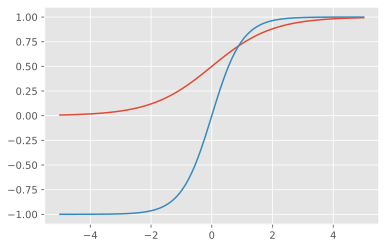

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def tanh(x):
  return np.tanh(x)

x = np.linspace(-5, 5, 100)
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)

fig, ax = plt.subplots()
ax.plot(x, y_sigmoid)
ax.plot(x, y_tanh)
plt.show()

Let's refer to the definition of $\text{tanh}$ to derive an expression for its derivative (no pun intended).

$$
\begin{align}
\frac{d}{dx} \text{tanh}(x) 
&= \frac{d}{dx} \left[ \frac{e^x - e^{-x}}{e^x + e^{-x}} \right] \\
&= 1 - \left(\frac{e^x - e^{-x}}{e^x + e^{-x}}\right)^2 \\
&= 1 - \text{tanh}^2(x)
\end{align}
$$

Now comes the more complicated part. Thankfully, we've already done something very similar in the past when we were building a vanilla neural network from scratch. For instance, we know from [this post](https://jaketae.github.io/study/neural-net/#data-generation) that, given a cross entropy loss function, the gradient of the softmax layer can simply be calculated by subtracting the predicted probabiity from the true distribution. In other words, given an intermediate variabe

$$
\begin{align}
z = W_y h_t + b_y \tag{8} \\
\hat{y} = \text{softmax}(z) \tag{7}
\end{align}
$$

we know that 

$$
\frac{dL}{dz} = \hat{y} - y 
$$

Note that $\hat{y}$ is denoted as `prob` in the code segment.

Since we have this information, now it's just a matter of back propagating the gradients to the lower segments of the acyclic graph that defines the neural network. Given (8), it only makes sense to continue with the next parameter, $W_y$. 

$$
\begin{align}
\frac{dL}{d W_y} 
&= \frac{dL}{dz} \cdot \frac{dz}{d W_y} \\
&= {h_t}^\top (\hat{y} - y)
\end{align}
$$

The transpose or the order in which the terms are multiplied may be confusing, but with just some scratch work on paper, it isn't difficult to verify these gradients by checking their dimensions. 

The equation for $b_y$ is even simpler, since there is no matrix multiplication involved. Thus, the gradient flows backwards without any modification.

$$
\frac{dL}{d b_y} = \frac{dL}{dz} = \hat{y} - y
$$

Moving down a layer, we come across (6):

$$
h_t = o_t \odot \text{tanh}(C_t) \tag{6}
$$

Let's begin by trying to find the gradient for $h$. 

$$
\begin{align}
\frac{dL}{dh_t} 
&= \frac{dL}{dz} \cdot \frac{dz}{dh_t} + \frac{dL}{d h_t} \\
&= (\hat{y} - y) {W_y}^\top + \frac{dL}{d h_t}
\end{align}
$$

You might be wondering what the $d h_t$ term is doing in that equation. After all, isn't that quantity precisely what we are tryihg to calculate? This is the one tricky yet also interesting part about RNN backpropagation. Recall that the whole point of a recurrent neural network is its use of variables from the previous forward pass. For example, we know that in the next forward pass, $h_t$ will be concatenated with the input $x_{t + 1}$. In the backpropagation step corresponding to that forward pass, we would have computed $d h_t$; thus, this gradient flows into the current backpropagation as well. 

Although this diagram applies to a standard RNN instead of an LSTM, the recurrent nature of backprop still stands. I present it here becasue I find this diagram to be very intuitive.

![png](https://i.imgur.com/hEtvXnN.png)

If you look at the right, the star represents the gradient from the last pass. If you look to the left, you will see that there is going to be a gradient for $h_{t - 2}$ that will eventually be passed over to the next backpropgation scheme. Since the forward pass is recurrent, so is the backward pass. 


Since we have $d h_t$, now it's time to move further. Let's derive the expression for the gradient for $o_t$. 

$$
\begin{align}
h_t = o_t \odot \text{tanh}(C_t) \tag{6} \implies \\
\frac{dL}{d o_t} 
&= \frac{dL}{d h_t} \cdot \frac{d h_t}{d o_t} \\
&= \frac{dL}{d h_t} \cdot \text{tanh}(C_t)
\end{align}
$$

Let's do the same for the other term, $\text{tanh}(C_t)$. To make things easier, let's make a quick substitution with an intermediate variable, i.e. let $a_C = \text{tanh}(C_t)$. Then, 

$$
\begin{align}
\frac{dL}{d a_C} 
&= \frac{dL}{dh_t} \cdot \frac{dh}{d a_C} \\
&= \frac{dL}{dh_t} \cdot o_t
\end{align}
$$

But $a_C$ was just an intermediate variable. How can we get the gradient for $C_t$ itself? Well, since the only transformation was just a $\text{tanh}$, chain rule tells us that all we need is to multiply the antiderivative of $\text{tanh}$, which we already derived above. Also keep in mind that since $C$ is a recurrent variable, we have to apply the gradient from the next call as well, just like $h$. 

$$
\begin{align}
\frac{dL}{d C_t} 
&= \frac{dL}{d a_C} \cdot \frac{d a_C}{d C_t} + \frac{dL}{d C_t} \\
&= \frac{dL}{dh_t} \cdot o_t \cdot (1 - \text{tanh}^2(C_t)) + \frac{dL}{d Ct}
\end{align}
$$

Note that all we had to do is to multiply the `d_tangent()` function we derived above, then add the backpropgation from the next iteration to account for the recurrent nature of the network. 

We still have a decent amount of work to do, but the fortunate news is that once we derive an expression for one parameter, the rest can also be obtained in an identical fashion. Therefore, for the sake of demonstration, we will only deal with $W_o$ and $b_o$. 

Let's start with the easier of the two, $b_o$. Recall that 

$$
o_t = \sigma(W_o [h_{t - 1}, x_t] + b_o) \tag{5}
$$

As we have done earlier, let's introduce an intermediate variable, $a_o = W_o [h_{t - 1}, x_t] + b_o$, and try deriving the gradient for that variable. Note that with this substitution, $o_t = \sigma(a_o)$. 

$$
\begin{align}
\frac{dL}{d a_o} 
&= \frac{dL}{d o_t} \cdot \frac{d o_t}{d a_o} \\
&= \frac{dL}{d h_t} \cdot \text{tanh}(C_t) \cdot \sigma(o_t) (1 - \sigma(o_t))
\end{align}
$$

Now we can move onto deriving the expressions for the gradient of the actual parameters, starting with $b_o$. This is extremely simple since $a_o$ and $b_o$ are defined by a linear relationship. 

$$
\begin{align}
\frac{dL}{d b_o} 
&= \frac{dL}{d a_o} \cdot \frac{d a_o}{d b_o} \\
&= \frac{dL}{d a_o}
\end{align}
$$

The next in line is $W_o$. This is also very simple, since all we need to do is to consider one instance of matrix multiplication. 

$$
\begin{align}
\frac{dL}{d W_o} 
&= \frac{dL}{d a_o} \cdot \frac{d a_o}{d W_o} \\
&= X^\top \frac{dL}{d a_o}
\end{align}
$$

where, given a concatenation operator $\vert$,

$$
X = (x_t \vert h_{t - 1})
$$

Now we are done! The gradient for the rest of the parameters, such as $d W_f$ or $d b_f$ look almost exactly the same as $d W_o$ and $d b_o$ respectively, and not without reason: as we have noted above, what I conveniently called the filter-and-raw-material structure of LSTM gates remain consistent across the forget, input, and output gates. Therefore, we can apply the same chain rule to arrive at the same expressions. 

However, there is one more caveat that requires our last bit of attention, and that is the gradient for $h_{t - 1}$. Note that $h_{t - 1}$ had been concatenated to the input in the form of $[x_t, h_{t - 1}]$ throughout the forward pass. Because this was a variable that was used during computation, we need to calculate its gradient as well. This might appear rather confusing since we are currently looking at time $t$, and it seems as if the gradient for $t - 1$ variables should be happeneing in the next iteration of backpropagation. While this is certainly true for the most part, due to the recurrent nature of LSTMs, we need to compute these gradients for $h_{t - 1}$ in this step as well. This is precisely what we were talking about earlier when discussing the recurrent nature of backprop; the $d h_{t - 1}$ we compute here will be used in the next iteration of backpropagation, just like we added $d h_t$ in the current backprop to calculate $d h_t$. 

Becaue $h_{t - 1}$ was used in many different places during the forward pass, we need to collect the gradients. Given an intermediate variable

$$
m_t = W_a X + b_a
$$

we can express the gradient in the following fashion:

$$
\begin{align}
\frac{dL}{dX} 
&= \sum_{a \in \{f, i, c, o \}} {\frac{dL}{dX}}_a \\
&= \sum_{a \in \{f, i, c, o \}} \frac{dL}{d a_t} \cdot \frac{d a_t}{d m_t} \cdot \frac{d m_t}{d X} \\
&= \sum_{a \in \{f, i, c, o \}} \frac{dL}{d a_t} \cdot \frac{d a_t}{d m_t} \cdot {W_a}^\top
\end{align}
$$

Then, we can obtain $d h_{t - 1}$ by un-concatenation:

$$
\frac{dL}{d h_{t - 1}} = {\left(\frac{dL}{dX}_{i, j} \right)}_{\substack{1 \le j \le H}}
$$

where $H$ denotes the number of neurons in the LSTM layer. 

We can do the same for $C_{t - 1}$. This is a lot simpler:

$$
\begin{align}
\frac{dL}{d C_{t - 1}} 
&= \frac{dL}{dC} \cdot \frac{dC}{d C_{t - 1}} \\
&= \frac{dL}{d C_t} \cdot f_t
\end{align}
$$

These gradients, of course, will be passed onto the next iteration of backpropagation, just like we had assumed that the values of $d C_t$ and $d h_t$ were given from the previous sequence of backpropagation. 

# Conclusion

Because DL libraries make it extremely easy to declare and train LSTM networks, it's often easy to gloss over what actually happens under the hood. However, there is certainly merit to dissecting and trying to understand the innerworking of DL models like LSTM cells, which offer a fascinating way of understanding the notion of memory. This is also important since RNNs are the basis of other more complicated models such as attention-based models or transformers, which is arguably the hottest topic these days in the field of NLP with the introduction of GPT-3 by OpenAI. 

I hope you have enjoyed reading this post. Catch you up in the next one!